In [1]:
%load_ext tensorboard
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from datetime import datetime


#name of model or experiment
model_name = "Q_Model"
log_dir= model_name + "/runs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=0,
    write_graph=True
    )


%tensorboard --logdir $log_dir

checkpoint_path = model_name + "/epoch_checkpoints/cp-{epoch:04d}.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
   checkpoint_path, verbose=1, save_weights_only=True,
   # Save weights, every epoch.
   save_freq='epoch')


n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_batches = 64     # Size of the batches

np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator


mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()


tf.config.get_visible_devices()


2024-05-19 22:17:08.488510: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 22:17:09.237440: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

n_qubits = 4

rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

dev = qml.device("default.qubit.tf", wires=n_qubits)





2024-05-19 22:17:14.051796: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6795 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:b3:00.0, compute capability: 7.5


In [3]:
keras.utils.get_custom_objects().clear()

@keras.utils.register_keras_serializable(package=(model_name+"_Layer"))
class ConvQLayer(keras.layers.Layer):
    

    #replace the contents of qnode with experiment circuit
    @qml.qnode(dev, interface='tf')
    def q_node(inputs):
        inputs *= np.pi
        # Encoding of 4 classical input values
        #Further testing of the AngleEmbedding function is needed
        qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')
        # Filter from arxiv.org/abs/2308.14930

        qml.CNOT(wires=[1, 2])
        qml.CNOT(wires=[0, 3])

        # Measurement producing 4 classical output values
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

    def call(self, inputs):

        #14x14 flattened 2x2 squares
        get_subsections_14x14 = lambda im : tf.reshape(tf.unstack(tf.reshape(im,[14,2,14,2]), axis = 2),[14,14,4])
        '''
        example of sequential flat 28x28 indexes after above shuffle
        [
            [
                [  0,   1,  28,  29],
                [ 56,  57,  84,  85],
                ...
                [672, 673, 700, 701],
                [728, 729, 756, 757]
            ],
            [
                [  2,   3,  30,  31],
                ...
                [730, 731, 758, 759]
            ],
            ...
            [
                [ 26,  27,  54,  55],
                ...
                [754, 755, 782, 783]
            ]
        '''

        #unpack 14x14 row by row
        list_squares_2x2 = lambda image_subsections: tf.reshape(tf.unstack(image_subsections, axis = 1), [196,4])


        #send 4 values to quantum function
        process_square_2x2 = lambda square_2x2 : self.q_node(square_2x2)

        #send all squares to the quantum function wrapper
        process_subsections = lambda squares: tf.vectorized_map(process_square_2x2,squares)

        #recompile the larger square
        separate_channels = lambda channel_stack: tf.reshape(channel_stack, [14,14,4])
        #each smaller square (channel) can be extracted as [:, :, channel]
        
        #apply function across batch
        preprocessing = lambda input: tf.vectorized_map(
            lambda image:(separate_channels(tf.transpose(process_subsections(list_squares_2x2(get_subsections_14x14(image)))))),
            input
        )

        return preprocessing(inputs)

qlayer = ConvQLayer()

qlayer.trainable = False

In [4]:
#wrap preprocessing in model

@keras.utils.register_keras_serializable(package=(model_name+"_Pre_Model"))
def Pre_Model():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        qlayer
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model
pre_model = Pre_Model()

In [5]:
#core model

@keras.utils.register_keras_serializable(package=(model_name+"_Core_Model"))
def Q_Model():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

q_model = Q_Model()

#preprocessing
pre_train_images = pre_model.predict(train_images,batch_size=n_batches)
pre_test_images = pre_model.predict(test_images,batch_size=n_batches)

#training
q_history = q_model.fit(
    pre_train_images,
    train_labels,
    validation_data=(pre_test_images, test_labels),
    batch_size = n_batches,
    epochs=n_epochs,
    verbose=2, callbacks=[tensorboard_callback, cp_callback]
)


I0000 00:00:1716157036.387770    1585 service.cc:145] XLA service 0x766f58013f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716157036.387839    1585 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2024-05-19 22:17:16.434422: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-19 22:17:16.507064: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 16/938 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step

I0000 00:00:1716157037.513635    1585 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
Epoch 1/30

Epoch 1: saving model to Q_Model/epoch_checkpoints/cp-0001.weights.h5
938/938 - 4s - 4ms/step - accuracy: 0.8615 - loss: 0.4791 - val_accuracy: 0.9277 - val_loss: 0.2615
Epoch 2/30

Epoch 2: saving model to Q_Model/epoch_checkpoints/cp-0002.weights.h5
938/938 - 2s - 2ms/step - accuracy: 0.9271 - loss: 0.2515 - val_accuracy: 0.9385 - val_loss: 0.2166
Epoch 3/30

Epoch 3: saving model to Q_Model/epoch_checkpoints/cp-0003.weights.h5
938/938 - 2s - 2ms/step - accuracy: 0.9369 - loss: 0.2156 - val_accuracy: 0.9425 - val_loss: 0.1979
Epoch 4/30

Epoch 4: saving model to Q_Model/epoch_checkpoints/cp-0004.weights.h5
938/938 - 2s - 2ms/step - accuracy: 0.9424 - loss: 0.1968 - val_accuracy: 0.9445 - val_loss: 0.1878
Epoch 5/30

Epoch 5: saving model to Q_Model/epoch_checkpoints/cp-0005.weights.h5
938/938 - 2s - 3ms/step - accuracy: 0.9456 - loss: 0.1848 - val_accuracy: 0.9464 - val_loss: 0.1818
Epoch

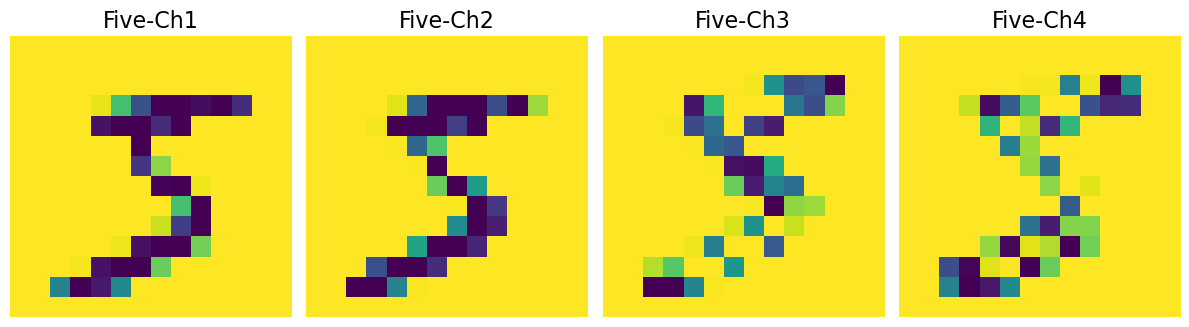

In [6]:
#example of quantum preprocessed(filtered) chanels
image_titles = ['Five-Ch1', 'Five-Ch2', 'Five-Ch3','Five-Ch4']
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(pre_train_images[0][:,:,i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()


In [7]:

#compare predictions with labels

from keras.models import Model

full_model = keras.models.Sequential([pre_model,q_model], name=model_name)

pred = full_model.predict(train_images[:n_batches], batch_size=n_batches)

print(np.argmax(pred, axis=1))

print(train_labels[:n_batches])



model_path = model_name + "/" + model_name + ".keras"
model_dir = os.path.dirname(model_path)

try:  
    os.mkdir(model_dir)  
except OSError as error:  
    print(error)   

full_model.export(model_path)



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 5 3 3 0 7 4 9 8 0 9 4 1 9 4 6 0]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 9 3 3 0 7 4 9 8 0 9 4 1 4 4 6 0]
[Errno 17] File exists: 'Q_Model'
INFO:tensorflow:Assets written to: Q_Model/Q_Model.keras/assets


INFO:tensorflow:Assets written to: Q_Model/Q_Model.keras/assets


Saved artifact at 'Q_Model/Q_Model.keras'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_5')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  130224755052176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  130224755054480: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [8]:
restored_as_layer = keras.layers.TFSMLayer(model_path, call_endpoint="serve")

restored_model = keras.models.Sequential([restored_as_layer], name=("Restored_"+model_name))

#view predictions of re-loaded model

print(np.argmax(restored_model.predict(train_images[:n_batches],batch_size=n_batches), axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7 3 8 6 9 0 5 6
 0 7 6 1 8 7 9 3 9 8 5 5 3 3 0 7 4 9 8 0 9 4 1 9 4 6 0]


In [9]:
restored_model.summary()

Model: "Restored_Q_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tfsm_layer (TFSMLayer)          │ (64, 10)               │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)